In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import joypy
import requests
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import tracemalloc
import time
import yellowbrick
from yellowbrick.regressor import ResidualsPlot, CooksDistance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import lime 
from lime import lime_tabular
import shap
shap.initjs()
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
prices = pd.read_csv('All-prices-1990-2021.csv')


In [3]:
prices

month  year        town  town_dummy flat_type block  \
0       1990-01  1990  ANG MO KIO           2    4 ROOM   308   
1       1990-01  1990  ANG MO KIO           2    3 ROOM   308   
2       1990-01  1990  ANG MO KIO           2    3 ROOM   216   
3       1990-01  1990  ANG MO KIO           2    3 ROOM   308   
4       1990-01  1990  ANG MO KIO           2    4 ROOM   211   
...         ...   ...         ...         ...       ...   ...   
840913  2021-03  2021      YISHUN           5    3 ROOM   110   
840914  2021-03  2021      YISHUN           5    3 ROOM   712   
840915  2021-03  2021      YISHUN           5    2 ROOM  424B   
840916  2021-03  2021      YISHUN           5    2 ROOM   459   
840917  2021-03  2021      YISHUN           5    2 ROOM   459   

             street_name                         address  latitude  \
0       ANG MO KIO AVE 1  308 ANG MO KIO AVE 1 SINGAPORE  1.365485   
1       ANG MO KIO AVE 1  308 ANG MO KIO AVE 1 SINGAPORE  1.365485   
2       ANG MO KIO AVE 1  216 ANG MO KIO AVE 1 SINGAPORE  1.366272   
3       ANG MO KIO AVE 1  308 ANG MO KIO AVE 1 SINGAPORE  1.365485   
4       ANG MO KIO AVE 3  211 ANG MO KIO AVE 3 SINGAPORE  1.369226   
...                  ...                             ...       ...   
840913    YISHUN RING RD    110 YISHUN RING RD SINGAPORE  1.433340   
840914      YISHUN AVE 5      712 YISHUN AVE 5 SINGAPORE  1.430248   
840915     YISHUN AVE 11    424B YISHUN AVE 11 SINGAPORE  1.423215   
840916     YISHUN AVE 11     459 YISHUN AVE 11 SINGAPORE  1.421059   
840917     YISHUN AVE 11     459 YISHUN AVE 11 SINGAPORE  1.421059   

         longitude  ... price_psm_yearly  Core CPI  price cpi_adj  \
0       103.844025  ...        10.997442     61.59   139633.05730   
1       103.844025  ...         8.464849     61.59    95794.77188   
2       103.841465  ...         7.606769     61.59    76635.81750   
3       103.844025  ...         8.287972     61.59    76635.81750   
4       103.841652  ...        11.484353     61.59   129891.21610   
...            ...  ...              ...       ...            ...   
840913  103.829168  ...        66.650391    100.40   271912.35060   
840914  103.828862  ...        63.567362    100.40   266932.27090   
840915  103.848264  ...        59.482956    100.40   258964.14340   
840916  103.846357  ...        57.234432    100.40   249003.98410   
840917  103.846357  ...        48.076923    100.40   209163.34660   

       price_psm cpi_adj  bala lease pct  price lease_adj implied  \
0            1517.750623            92.9              88869.75242   
1            1168.228925            92.9              60968.78364   
2            1049.805719            92.9              48775.02691   
3            1143.818172            92.9              48775.02691   
4            1603.595261            93.3              82315.11254   
...                  ...             ...                      ...   
840913       4248.630478            82.4             318058.25240   
840914       3925.474573            81.2             316847.29060   
840915       5509.875392            95.2             262184.87390   
840916       5187.583001            94.8             253164.55700   
840917       4357.569721            94.8             212658.22780   

        price_psm lease_adj implied  price cpi_lease_adj implied  \
0                        965.975570                 144292.50270   
1                        743.521752                  98991.36814   
2                        668.151054                  79193.09451   
3                        727.985476                  79193.09451   
4                       1016.235957                 133650.12590   
...                             ...                          ...   
840913                  4969.660194                 316791.08810   
840914                  4659.518980                 315584.95080   
840915                  5578.401574                 261140.31270   
840916                  5274.261603               

In [4]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840918 entries, 0 to 840917
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   month                            840918 non-null  object 
 1   year                             840918 non-null  int64  
 2   town                             840918 non-null  object 
 3   town_dummy                       840918 non-null  int64  
 4   flat_type                        840918 non-null  object 
 5   block                            840918 non-null  object 
 6   street_name                      840918 non-null  object 
 7   address                          840918 non-null  object 
 8   latitude                         840918 non-null  float64
 9   longitude                        840918 non-null  float64
 10  storey_range                     840918 non-null  object 
 11  storey                           840918 non-null  int64  
 12  ar

In [5]:
prices.shape

(840918, 28)

With 840918 rows as shown above, it is too large for data training.
I might only select last 5 years to train data.

### Checking for null value

As we can see below, there is no null value for the entire database.
Perhaps as this data was tabulated from government sources, hence, high possibility all information are correctly updated.

<AxesSubplot:>

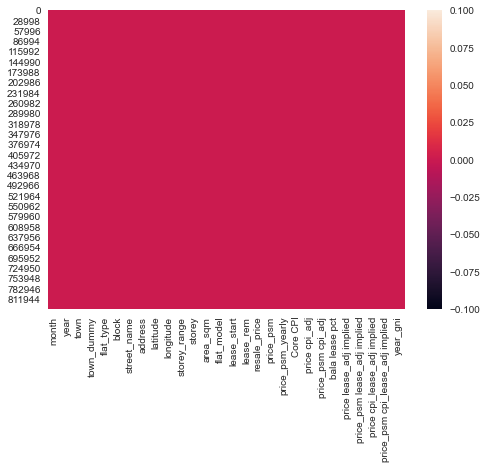

In [6]:
sns.heatmap(prices.isnull(), cbar=True)

In [7]:
# Converting the month column as a Datetime object (to datetime)
prices['month'] = pd.to_datetime(prices['month']) 

In [8]:
# To get the unique values of year (to be certain that the data really cover from 1990 till 2021)
prices['month'].dt.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype=int64)

In [9]:
# Getting every flat_type unique values
prices['flat_type'].unique()

array(['4 ROOM', '3 ROOM', '1 ROOM', '5 ROOM', 'EXECUTIVE', '2 ROOM',
       'MULTI GENERATION'], dtype=object)

In [10]:
# Getting every flat_type unique values
prices['flat_model'].unique()

array(['New Generation', 'Improved', 'Standard', 'Model A', 'Apartment',
       'Maisonette', 'Model A-Maisonette', 'Simplified', 'Terrace',
       '2-ROOM', 'Improved-Maisonette', 'MULTI GENERATION',
       'Premium Apartment', 'Multi Generation', 'Adjoined flat',
       'Premium Maisonette', '2-room', 'Model A2', 'DBSS', 'Type S1',
       'Type S2', 'Premium Apartment Loft'], dtype=object)

In [11]:
# Find out number of rows for every flat type
prices['flat_type'].value_counts()

4 ROOM              315272
3 ROOM              275698
5 ROOM              174260
EXECUTIVE            63838
2 ROOM               10059
1 ROOM                1280
MULTI GENERATION       511
Name: flat_type, dtype: int64

In [12]:
# Find out number of rows for every flat model
prices['flat_model'].value_counts()

Model A                   233098
Improved                  221001
New Generation            179236
Simplified                 54422
Standard                   40278
Premium Apartment          36776
Apartment                  32596
Maisonette                 27388
Model A2                    9232
DBSS                        1957
Model A-Maisonette          1921
Adjoined flat               1112
Terrace                      652
Type S1                      293
MULTI GENERATION             279
Multi Generation             232
Type S2                      146
Improved-Maisonette          116
Premium Maisonette            83
Premium Apartment Loft        57
2-room                        22
2-ROOM                        21
Name: flat_model, dtype: int64

#### Changing the Capitalized columns into capital for first letter of a word.
For maintaining conventional use and consitency.

In [13]:
# Rename flat model categories into correct spelling
Clean_name = {'MULTI GENERATION':'Multi Generation', '2-ROOM':'2-room'}
prices = prices.replace({'flat_model': Clean_name})

prices['flat_model'].value_counts()

Model A                   233098
Improved                  221001
New Generation            179236
Simplified                 54422
Standard                   40278
Premium Apartment          36776
Apartment                  32596
Maisonette                 27388
Model A2                    9232
DBSS                        1957
Model A-Maisonette          1921
Adjoined flat               1112
Terrace                      652
Multi Generation             511
Type S1                      293
Type S2                      146
Improved-Maisonette          116
Premium Maisonette            83
Premium Apartment Loft        57
2-room                        43
Name: flat_model, dtype: int64

In [14]:
# Getting unique values on "range of floors" column
prices['storey_range'].unique()

array(['10 TO 12', '07 TO 09', '04 TO 06', '01 TO 03', '13 TO 15',
       '19 TO 21', '16 TO 18', '25 TO 27', '22 TO 24', '28 TO 30',
       '31 TO 33', '37 TO 39', '40 TO 42', '34 TO 36', '06 TO 10',
       '01 TO 05', '11 TO 15', '16 TO 20', '21 TO 25', '26 TO 30',
       '36 TO 40', '31 TO 35', '46 TO 48', '43 TO 45', '49 TO 51'],
      dtype=object)

In [15]:
#Changing town names into lower-case whereby only first letter is upper-case
prices['town'] = prices['town'].str.title()
# Finding all town names
prices['town'].unique()

array(['Ang Mo Kio', 'Bedok', 'Bishan', 'Bukit Batok', 'Bukit Merah',
       'Bukit Timah', 'Central Area', 'Choa Chu Kang', 'Clementi',
       'Geylang', 'Hougang', 'Jurong East', 'Jurong West',
       'Kallang/Whampoa', 'Marine Parade', 'Queenstown', 'Sengkang',
       'Serangoon', 'Tampines', 'Toa Payoh', 'Woodlands', 'Yishun',
       'Lim Chu Kang', 'Sembawang', 'Bukit Panjang', 'Pasir Ris',
       'Punggol'], dtype=object)

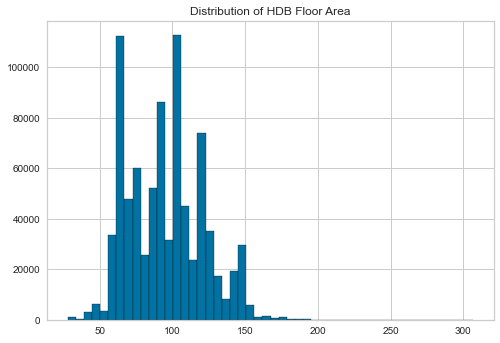

Terrace               61
Maisonette            15
Premium Maisonette     7
Apartment              4
Adjoined flat          1
Name: flat_model, dtype: int64

In [16]:
# Finding the number of flats based on size per property
plt.hist(prices['area_sqm'], bins=50, edgecolor='black')
plt.title('Distribution of HDB Floor Area')
plt.show()
display(prices[prices['area_sqm'] > 200]['flat_model'].value_counts())

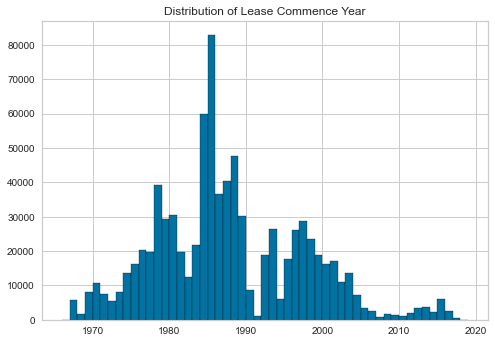

In [17]:
# Finding the number of flats sold per year
bins = prices['lease_start'].max() - prices['lease_start'].min()
plt.hist(prices['lease_start'], bins=bins, edgecolor='black')
plt.title('Distribution of Lease Commence Year')
plt.show()

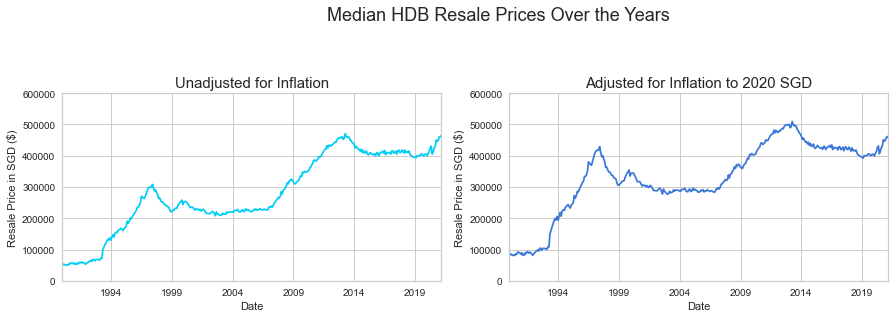

In [18]:
# Plot Median Resale Prices Over the Years
fig = plt.figure(figsize=(14,4.5))
fig.suptitle('Median HDB Resale Prices Over the Years', fontsize=18)

# Unadjusted
ax1 = fig.add_subplot(121)
prices.groupby('month')[['resale_price']].median().plot(ax=ax1, color='#00cef6', legend=None)
ax1.set_xlabel('Date'), ax1.set_ylabel('Resale Price in SGD ($)'), ax1.set_ylim(0, 600000), ax1.set_title('Unadjusted for Inflation', size=15)

# Adjusted with inflation
ax2 = fig.add_subplot(122)
prices.groupby('month')[['price cpi_adj']].median().plot(ax=ax2, color='#3c78d8', legend=None)
ax2.set_xlabel('Date'), ax2.set_ylabel('Resale Price in SGD ($)'), ax2.set_ylim(0, 600000), ax2.set_title('Adjusted for Inflation to 2020 SGD',size=15)


plt.tight_layout(rect=[0, 0, 0.9, 0.9]) 
plt.show()


### Price tide
We noticed that there are 2 points where price was at an all time-high and then a sudden drop. 
This happens in 1997 and 2012. 
In 1997 is the financial Asian crisis and in 2012 is the Government implementation of 'price-cooling' policy.

In [19]:
prices_3room = prices[prices['flat_type'] == "3 ROOM"]
prices_4room = prices[prices['flat_type'] == "4 ROOM"]

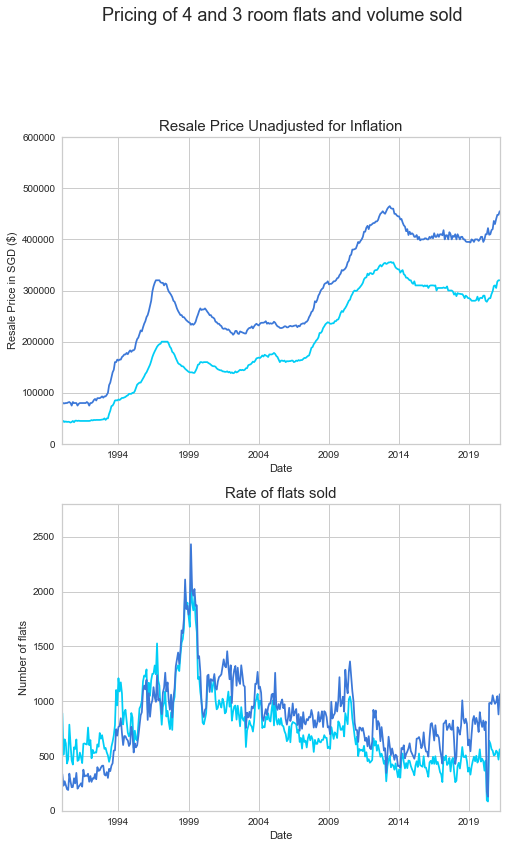


 Label in dark blue: 4 room flat 
 Label in light blue: 3 room flat'


In [20]:
# Plot Median Resale Prices Over the Years
fig = plt.figure(figsize=(8,12))
fig.suptitle('Pricing of 4 and 3 room flats and volume sold', fontsize=18)

# Unadjusted
ax1 = fig.add_subplot(211)
prices_3room.groupby('month')[['resale_price']].median().plot(ax=ax1, color='#00cef6', legend= None)
prices_4room.groupby('month')[['resale_price']].median().plot(ax=ax1, color='#3c78d8', legend= None)
ax1.set_xlabel('Date'), ax1.set_ylabel('Resale Price in SGD ($)'), ax1.set_ylim(0, 600000), ax1.set_title('Resale Price Unadjusted for Inflation', size=15)

# Adjusted with inflation
ax2 = fig.add_subplot(212)
prices_3room.groupby('month')[['flat_type']].count().plot(ax=ax2, color='#00cef6', legend= None)
prices_4room.groupby('month')[['flat_type']].count().plot(ax=ax2, color='#3c78d8', legend= None)
ax2.set_xlabel('Date'), ax2.set_ylabel('Number of flats'), ax2.set_ylim(0, 2800), ax2.set_title('Rate of flats sold',size=15)


plt.tight_layout(rect=[0, 0, 0.9, 0.9]) 
plt.show()
print("\n Label in dark blue: 4 room flat \n Label in light blue: 3 room flat'")

### Rates rise an fall for both 3 and 4 room flats in tandem
However, we also notice that from 2014 onwards, there are more 4-room flat transactions.
We can also see below that based on recent 2015 to 2020 purchase of houses, most are with high leases remaining.

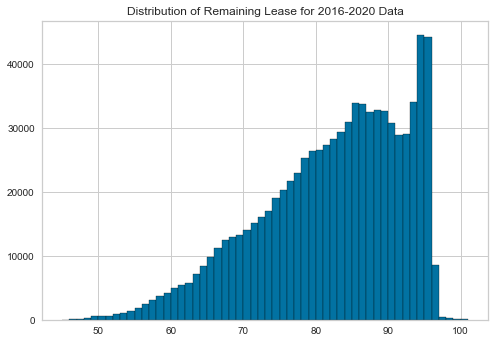

In [21]:
bins = prices['lease_rem'].max() - prices['lease_rem'].min()
plt.hist(prices['lease_rem'], bins=int(bins), edgecolor='black')
plt.title('Distribution of Remaining Lease for 2016-2020 Data')
plt.show()

In [22]:
prices.head()

month  year        town  town_dummy flat_type block       street_name  \
0 1990-01-01  1990  Ang Mo Kio           2    4 ROOM   308  ANG MO KIO AVE 1   
1 1990-01-01  1990  Ang Mo Kio           2    3 ROOM   308  ANG MO KIO AVE 1   
2 1990-01-01  1990  Ang Mo Kio           2    3 ROOM   216  ANG MO KIO AVE 1   
3 1990-01-01  1990  Ang Mo Kio           2    3 ROOM   308  ANG MO KIO AVE 1   
4 1990-01-01  1990  Ang Mo Kio           2    4 ROOM   211  ANG MO KIO AVE 3   

                          address  latitude   longitude  ... price_psm_yearly  \
0  308 ANG MO KIO AVE 1 SINGAPORE  1.365485  103.844025  ...        10.997442   
1  308 ANG MO KIO AVE 1 SINGAPORE  1.365485  103.844025  ...         8.464849   
2  216 ANG MO KIO AVE 1 SINGAPORE  1.366272  103.841465  ...         7.606769   
3  308 ANG MO KIO AVE 1 SINGAPORE  1.365485  103.844025  ...         8.287972   
4  211 ANG MO KIO AVE 3 SINGAPORE  1.369226  103.841652  ...        11.484353   

   Core CPI  price cpi_adj price_psm cpi_adj  bala lease pct  \
0     61.59   139633.05730       1517.750623            92.9   
1     61.59    95794.77188       1168.228925            92.9   
2     61.59    76635.81750       1049.805719            92.9   
3     61.59    76635.81750       1143.818172            92.9   
4     61.59   129891.21610       1603.595261            93.3   

   price lease_adj implied  price_psm lease_adj implied  \
0              88869.75242                   965.975570   
1              60968.78364                   743.521752   
2              48775.02691                   668.151054   
3              48775.02691                   727.985476   
4              82315.11254                  1016.235957   

   price cpi_lease_adj implied  price_psm cpi_lease_adj implied  year_gni  
0                 144292.50270                      1568.396769     22901  
1                  98991.36814                      1207.211806     22901  
2                  79193.09451                      1084.836911     22901  
3                  79193.09451                      1181.986486     22901  
4                 133650.12590                      1650.001555     22901  

[5 rows x 28 columns]

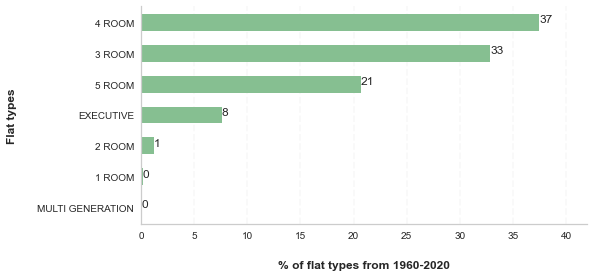

In [23]:
import matplotlib.ticker as ticker

flattype1 = prices.set_index('month')['1990':'2020'].reset_index()['flat_type'].value_counts()/len(prices.set_index('month')['1990':'2020'].reset_index())*100
flattype = flattype1.sort_values().tail(15)
ax = flattype.plot(kind='barh', figsize=(8, 4), color='#86bf91', zorder=2, width=0.55, grid=False)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", 
               labelbottom="on", left="off", right="off", labelleft="on")

# Display value of % for every bar
for index, value in enumerate(flattype):
    plt.text(value , index, round(value))
    
# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("% of flat types from 1960-2020", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Flat types", labelpad=20, weight='bold', size=12)


# Format y-axis label
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

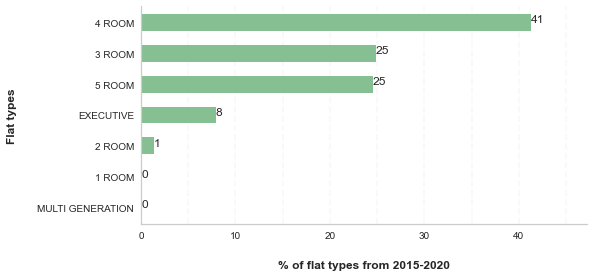

In [24]:

flattype2 = prices.set_index('month')['2015':'2020'].reset_index()['flat_type'].value_counts()/len(prices.set_index('month')['2015':'2020'].reset_index())*100
flattype = flattype2.sort_values().tail(15)
ax = flattype.plot(kind='barh', figsize=(8, 4), color='#86bf91', zorder=2, width=0.55, grid=False)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", 
               labelbottom="on", left="off", right="off", labelleft="on")

# Display value of % for every bar
for index, value in enumerate(flattype):
    plt.text(value , index, round(value))
    
# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("% of flat types from 2015-2020", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Flat types", labelpad=20, weight='bold', size=12)

# Format y-axis label
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

### 4 room flat dominate market share
Based from past 5 years, 4 room flats take up the majority of the flat-type distribution and is growing as compared to 1960 and 2020.

In [25]:
flattype = ['3 ROOM','4 ROOM','5 ROOM','EXECUTIVE']
prices1520 = prices.set_index('month').sort_index().loc['2015-01':'2020-12']
prices1520 = prices1520[prices1520['flat_type'].isin(flattype)][['flat_type','resale_price']].reset_index()
prices1520['flat_type_year'] = prices1520['flat_type'] + ' - ' + prices1520['month'].apply(lambda x: str(x)[:4])
prices1520

month flat_type  resale_price flat_type_year
0      2015-01-01    3 ROOM      255000.0  3 ROOM - 2015
1      2015-01-01    3 ROOM      275000.0  3 ROOM - 2015
2      2015-01-01    3 ROOM      285000.0  3 ROOM - 2015
3      2015-01-01    3 ROOM      290000.0  3 ROOM - 2015
4      2015-01-01    3 ROOM      290000.0  3 ROOM - 2015
...           ...       ...           ...            ...
122962 2020-12-01    3 ROOM      270000.0  3 ROOM - 2020
122963 2020-12-01    3 ROOM      265000.0  3 ROOM - 2020
122964 2020-12-01    3 ROOM      265000.0  3 ROOM - 2020
122965 2020-12-01    3 ROOM      260000.0  3 ROOM - 2020
122966 2020-12-01    3 ROOM      240000.0  3 ROOM - 2020

[122967 rows x 4 columns]

## Data selection
As the data is very large if I select all 1990-2021, I decided to take only from 2015-2020 for training to compute faster.
2021 is not selected as it is not for a full year.

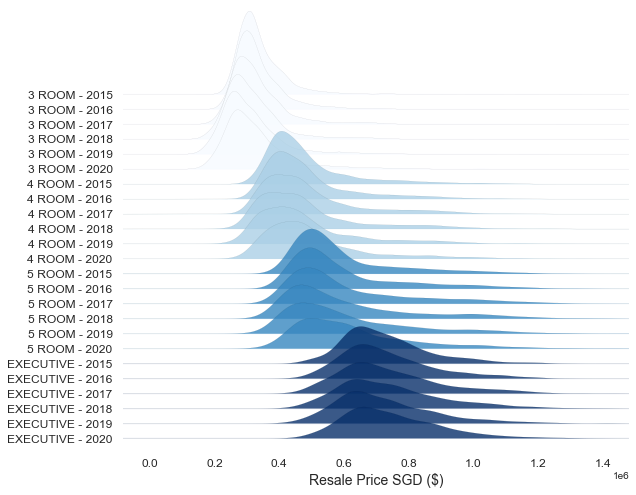

In [26]:
# ridgeline plot for looking at distribution of flat types by year 2015-2020
fig, axes = joypy.joyplot(prices1520, by="flat_type_year", column="resale_price",figsize=(9,7),
             linewidth=0.05,overlap=1.5,alpha=0.8,colormap=plt.cm.get_cmap('Blues',4))
axes[1].set_xlim([0,1200000])
axes[1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k', '1200k' , '1400k']) 
plt.xlabel('Resale Price SGD ($)', fontsize=14)
fig.show()

### Data analysis
After getting information above to answer some business questions, below are created to see the changes between 2 periods.
We will use lollipop to view the mean price of every town and the percentage changes.

In [27]:
## # Calculating median price within 2015 to 2020
prices['year'] = pd.DatetimeIndex(prices['month']).year 
# Select only mean/average resale prices within the years selected. Group by town. Sort order in ascending. 
prices1520 = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020])].groupby(['town'], as_index=False).agg({'resale_price': 'mean'}).sort_values('resale_price', ascending=True).reset_index(drop=True)
# Divide the mean value by 1000 to show value in '000. eg. 100,000 as 100k
prices1520['resale_price'] = round(prices1520['resale_price']/1000)
#Assign colours or top lollipop to indicate the most expensive, different color for bottom lollipop. Remaining as same colour.
prices1520['color'] = ['#f04135'] + ['#1c55b0']*(len(prices1520)-2) + ['#109137']

# 4-room
prices1520_4room = prices[(prices['flat_type'].isin(['4 ROOM'])) & (prices['year'].isin([2015,2016,2017,2018,2019,2020]))].groupby(['town'], as_index=False).agg({'resale_price': 'mean'}).sort_values('resale_price', ascending=True).reset_index(drop=True)
prices1520_4room['resale_price'] = round(prices1520_4room['resale_price']/1000)
prices1520_4room['color'] = ['#f04135'] + ['#1c55b0']*(len(prices1520_4room)-2) + ['#109137']

# 3-room
prices1520_3room = prices[(prices['flat_type'].isin(['3 ROOM'])) & (prices['year'].isin([2015,2016,2017,2018,2019,2020]))].groupby(['town'], as_index=False).agg({'resale_price': 'mean'}).sort_values('resale_price', ascending=True).reset_index(drop=True)
prices1520_3room['resale_price'] = round(prices1520_3room['resale_price']/1000)
prices1520_3room['color'] = ['#f04135'] + ['#1c55b0']*(len(prices1520_3room)-2) + ['#109137']


## Calculating percentage change from 1997 vs 2020
# all room type
# Select only mean/average resale prices within the years selected. Group by town and year. Sort order in ascending. 
prices9720 = prices[prices['year'].isin([1997,2020])].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
# Find the change in percentage value from 2000 conpared to 1997
prices9720['change'] = prices9720.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices9720 = prices9720[prices9720['change'].notnull()] 
prices9720 = prices9720.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
# Assign different colours to indicate increase or decrease
prices9720['color'] = prices9720['change'].apply(lambda x: '#109137' if x > 0 else '#f8766d')

# 4-room
prices9720_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([1997,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices9720_4room['change'] = prices9720_4room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices9720_4room = prices9720_4room[prices9720_4room.change.notnull()]
prices9720_4room = prices9720_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices9720_4room['color'] = prices9720_4room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')

# 3-room
prices9720_3room = prices[(prices['flat_type'].isin(['3 ROOM']) & prices['year'].isin([1997,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices9720_3room['change'] = prices9720_3room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices9720_3room = prices9720_3room[prices9720_3room.change.notnull()]
prices9720_3room = prices9720_3room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices9720_3room['color'] = prices9720_3room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')


## Calculating percentage change from 2008 vs 2020
# all room type
prices0820 = prices[prices['year'].isin([2008,2020])].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices0820['change'] = prices0820.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices0820 = prices0820[prices0820['change'].notnull()] 
prices0820 = prices0820.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices0820['color'] = prices0820['change'].apply(lambda x: '#109137' if x > 0 else '#f8766d')

# 4-room
prices0820_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([2008,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices0820_4room['change'] = prices0820_4room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices0820_4room = prices0820_4room[prices0820_4room.change.notnull()]
prices0820_4room = prices0820_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices0820_4room['color'] = prices0820_4room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')

# 3-room
prices0820_3room = prices[(prices['flat_type'].isin(['3 ROOM']) & prices['year'].isin([2008,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices0820_3room['change'] = prices0820_3room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices0820_3room = prices0820_3room[prices0820_3room.change.notnull()]
prices0820_3room = prices0820_3room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices0820_3room['color'] = prices0820_3room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')

## Calculating percentage change from 2018 vs 2020
# all room type
prices1820 = prices[prices['year'].isin([2018,2020])].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices1820['change'] = prices1820.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices1820 = prices1820[prices1820['change'].notnull()] 
prices1820 = prices1820.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices1820['color'] = prices1820['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')

# 4-room
prices1820_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([2018,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices1820_4room['change'] = prices1820_4room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices1820_4room = prices1820_4room[prices1820_4room.change.notnull()]
prices1820_4room = prices1820_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices1820_4room['color'] = prices1820_4room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')

# 3-room
prices1820_3room = prices[(prices['flat_type'].isin(['3 ROOM']) & prices['year'].isin([2018,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices1820_3room['change'] = prices1820_3room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices1820_3room = prices1820_3room[prices1820_3room.change.notnull()]
prices1820_3room = prices1820_3room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices1820_3room['color'] = prices1820_3room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')


# Calculating mean price within 2018-2020
# all room type
prices1820_price = prices[prices['year'].isin([2018,2019,2020])].groupby(['town'], as_index=False).agg({'resale_price': 'mean'}).sort_values('resale_price', ascending=True).reset_index(drop=True)
prices1820_price['resale_price'] = round(prices1820_price['resale_price']/1000)
prices1820_price['color'] = ['#f04135'] + ['#1c55b0']*(len(prices1820_price)-2) + ['#109137']

# 4-room
prices1820_4room_price = prices[(prices['flat_type'].isin(['4 ROOM'])) & (prices['year'].isin([2015,2016,2017,2018,2019,2020]))].groupby(['town'], as_index=False).agg({'resale_price': 'mean'}).sort_values('resale_price', ascending=True).reset_index(drop=True)
prices1820_4room_price['resale_price'] = round(prices1820_4room_price['resale_price']/1000)
prices1820_4room_price['color'] = ['#f04135'] + ['#1c55b0']*(len(prices1820_4room_price)-2) + ['#109137']

# 3-room
prices1820_3room_price = prices[(prices['flat_type'].isin(['3 ROOM'])) & (prices['year'].isin([2015,2016,2017,2018,2019,2020]))].groupby(['town'], as_index=False).agg({'resale_price': 'mean'}).sort_values('resale_price', ascending=True).reset_index(drop=True)
prices1820_3room_price['resale_price'] = round(prices1820_3room_price['resale_price']/1000)
prices1820_3room_price['color'] = ['#f04135'] + ['#1c55b0']*(len(prices1820_3room_price)-2) + ['#109137']

## Calculating percentage change from 2000 vs 2020 price
# all room type
prices2020 = prices[prices['year'].isin([2000,2020])].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices2020['change'] = prices2020.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices2020 = prices2020[prices2020['change'].notnull()] 
prices2020 = prices2020.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices2020['color'] = prices2020['change'].apply(lambda x: '#109137' if x > 0 else '#f8766d')

# 4-room
prices2020_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([2000,2020]))].groupby(['town','year'], as_index=False).agg({'resale_price': 'mean'})
prices2020_4room['change'] = prices2020_4room.groupby('town')['resale_price'].apply(lambda x: x.pct_change()*100)
prices2020_4room = prices2020_4room[prices2020_4room.change.notnull()]
prices2020_4room = prices2020_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices2020_4room['color'] = prices2020_4room['change'].apply(lambda x: '#109137' if x > 0 else '#f04135')

In [28]:
# Function for lollipop charts
def loll_plot(df, x, y, subtitle, xlabel, xlim):
    plt.rc('axes', axisbelow=True)
    plt.grid(alpha=0.0)
    plt.hlines(y=df.index, xmin=0, xmax=df[x], color=df.color, linewidth=1)
    plt.scatter(df[x], df.index, color=df.color, s=300)
    for i, txt in enumerate(df[x]):
        plt.annotate(str(round(txt)), (txt, i), color='white', fontsize=9, ha='center', va='center')
    plt.annotate(subtitle, xy=(1, 0), xycoords='axes fraction', fontsize=9,
                    xytext=(-5, 5), textcoords='offset points',
                    ha='right', va='bottom')
    plt.yticks(df.index, df[y]); plt.xticks(fontsize=12); plt.xlim(xlim)
    plt.xlabel(xlabel, fontsize=14)

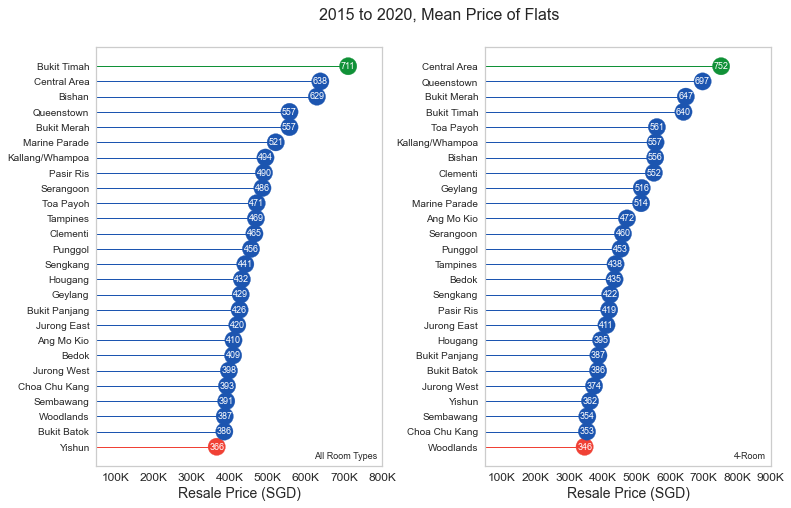

In [29]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices1520, 'resale_price', 'town', 'All Room Types', 'Resale Price (SGD)', [50,800])
ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()])
ax1.yaxis.set_ticks_position('none') 

ax2 = plt.subplot(122)
loll_plot(prices1520_4room, 'resale_price', 'town', '4-Room', 'Resale Price (SGD)', [50,900])
ax2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_xticks()])
ax2.yaxis.set_ticks_position('none') 

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2015 to 2020, Mean Price of Flats', fontsize=16)
plt.show()

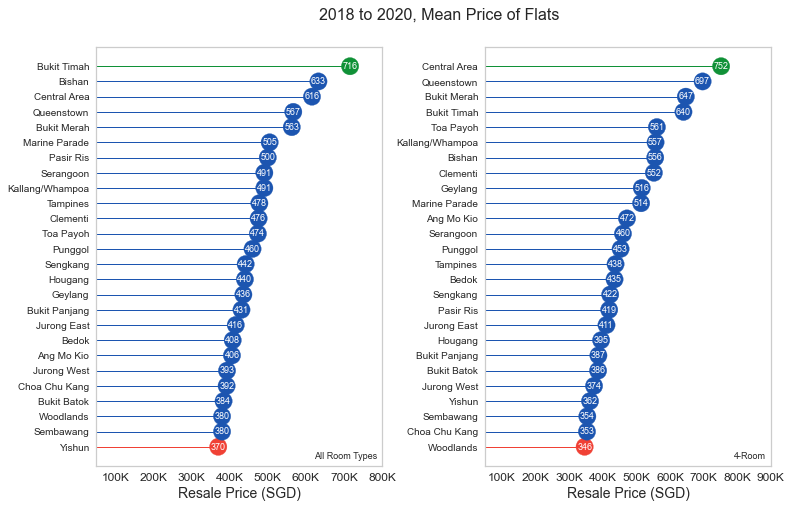

In [30]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices1820_price, 'resale_price', 'town', 'All Room Types', 'Resale Price (SGD)', [50,800])
ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()])
ax1.yaxis.set_ticks_position('none') 

ax2 = plt.subplot(122)
loll_plot(prices1820_4room_price, 'resale_price', 'town', '4-Room', 'Resale Price (SGD)', [50,900])
ax2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_xticks()])
ax2.yaxis.set_ticks_position('none') 

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2018 to 2020, Mean Price of Flats', fontsize=16)
plt.show()

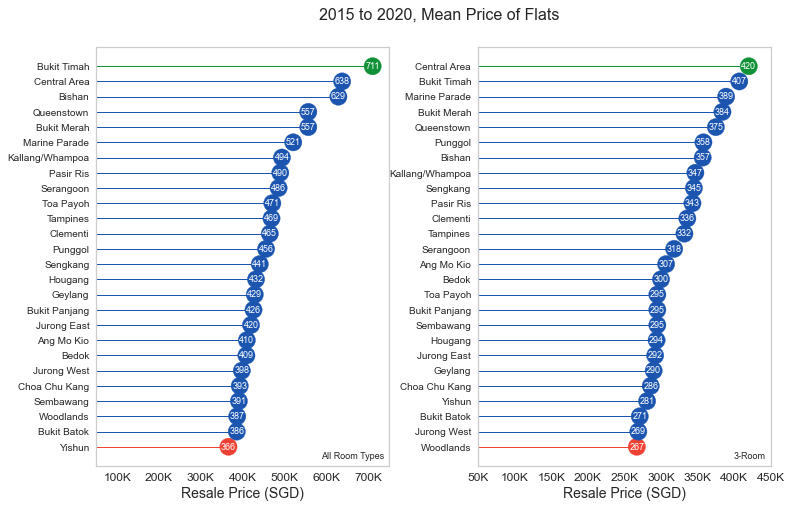

In [31]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices1520, 'resale_price', 'town', 'All Room Types', 'Resale Price (SGD)', [50,750])
ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()])
ax1.yaxis.set_ticks_position('none') 

ax2 = plt.subplot(122)
loll_plot(prices1520_3room, 'resale_price', 'town', '3-Room', 'Resale Price (SGD)', [50,450])
ax2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_xticks()])
ax2.yaxis.set_ticks_position('none') 

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2015 to 2020, Mean Price of Flats', fontsize=16)
plt.show()

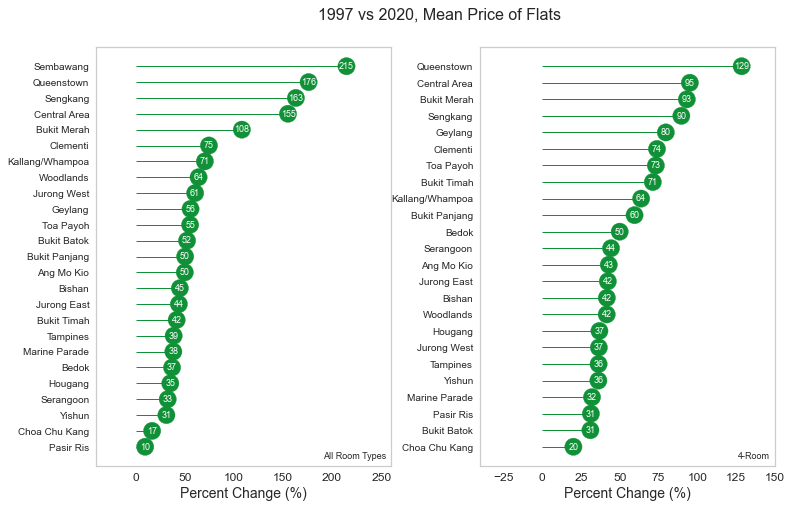

In [32]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices9720, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-40,260])

ax2 = plt.subplot(122)
loll_plot(prices9720_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [-40,150])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('1997 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

In [33]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices0820, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-40,100])

ax2 = plt.subplot(122)
loll_plot(prices0820_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [-40,80])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2008 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

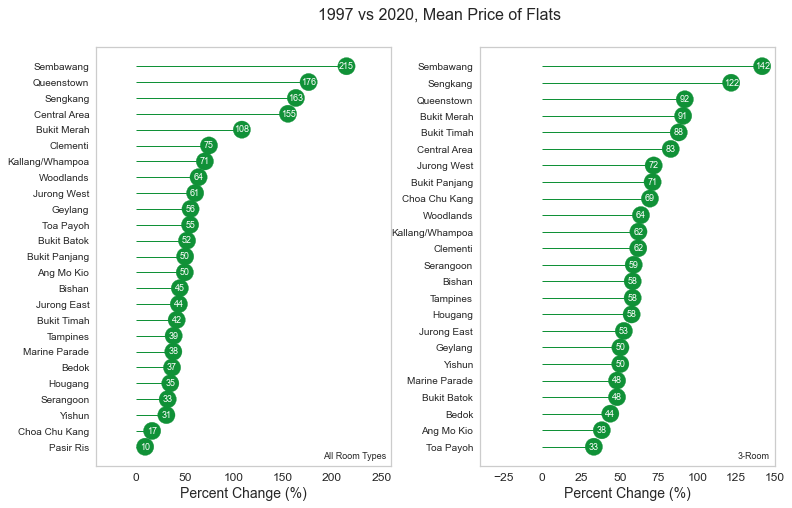

In [34]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices9720, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-40,260])

ax2 = plt.subplot(122)
loll_plot(prices9720_3room, 'change', 'town', '3-Room', 'Percent Change (%)', [-40,150])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('1997 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

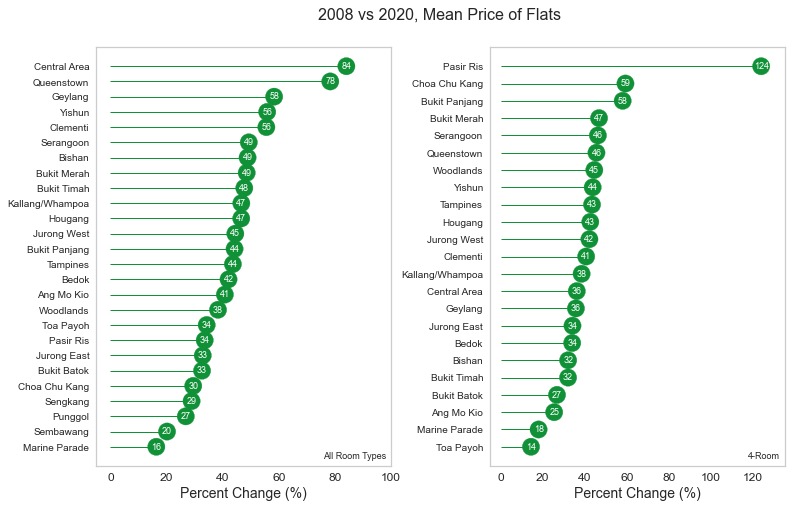

In [35]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices0820, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-5,100])

ax2 = plt.subplot(122)
loll_plot(prices0820_3room, 'change', 'town', '4-Room', 'Percent Change (%)', [-5,135])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2008 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

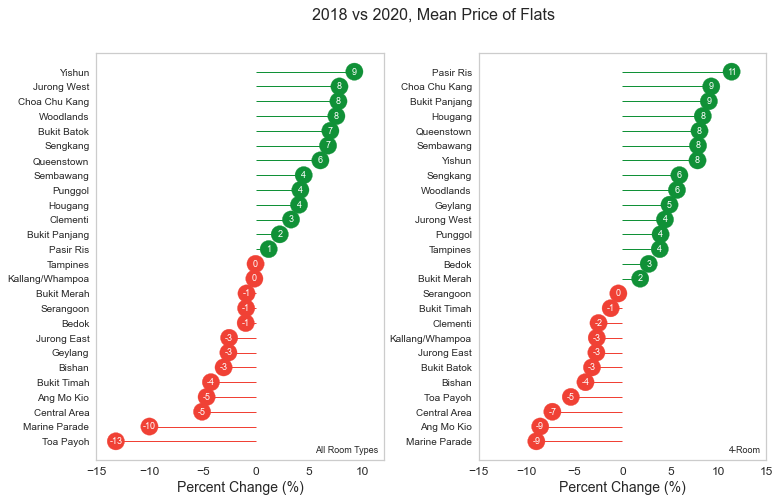

In [36]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices1820, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-15,12])

ax2 = plt.subplot(122)
loll_plot(prices1820_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [-15,15])

fig.tight_layout(pad=0.5, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2018 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

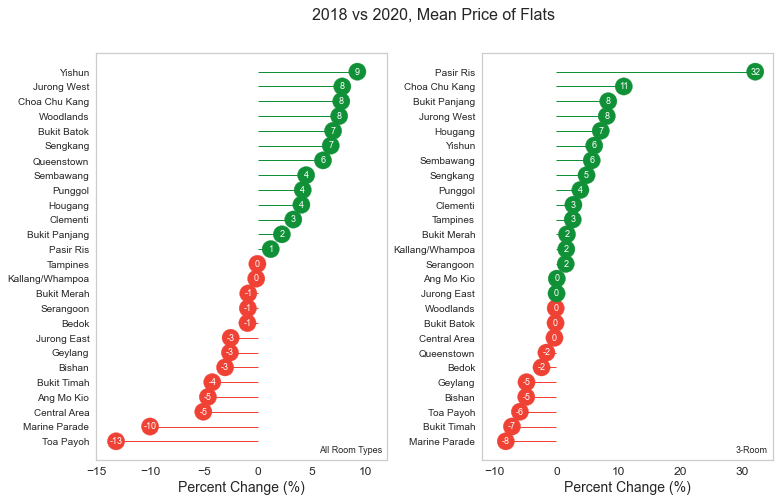

In [37]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices1820, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-15,12])

ax2 = plt.subplot(122)
loll_plot(prices1820_3room, 'change', 'town', '3-Room', 'Percent Change (%)', [-12,35])

fig.tight_layout(pad=0.5, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2018 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

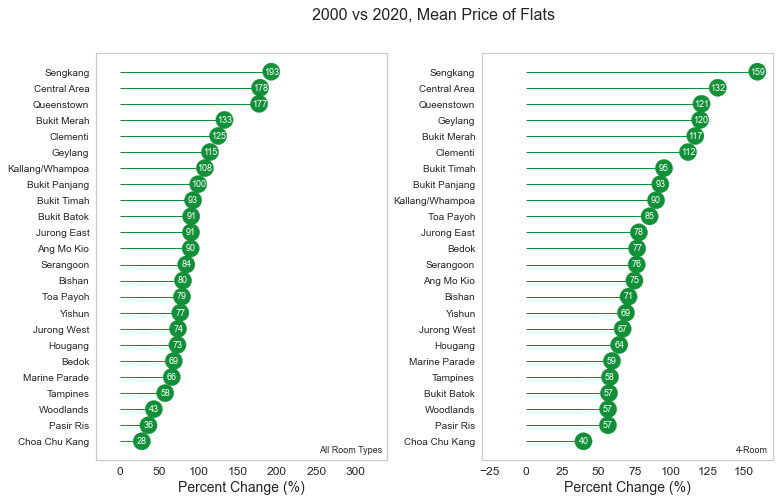

In [38]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices2020, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-30,340])

ax2 = plt.subplot(122)
loll_plot(prices2020_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [-30,170])

fig.tight_layout(pad=0.5, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2000 vs 2020, Mean Price of Flats', fontsize=16)
plt.show()

In [39]:
prices[prices['year'].isin([2020])].groupby('town')['lease_start'].median().sort_values()

town
Marine Parade      1975.0
Ang Mo Kio         1980.0
Bedok              1980.0
Clementi           1980.0
Kallang/Whampoa    1981.0
Toa Payoh          1982.0
Geylang            1982.0
Central Area       1983.0
Jurong East        1984.0
Bukit Merah        1984.0
Serangoon          1986.0
Bukit Batok        1986.0
Bukit Timah        1988.0
Bishan             1988.0
Tampines           1988.0
Yishun             1988.0
Hougang            1992.0
Pasir Ris          1995.0
Woodlands          1997.5
Jurong West        1998.0
Choa Chu Kang      1999.0
Queenstown         2000.0
Sembawang          2001.0
Bukit Panjang      2012.0
Sengkang           2013.0
Punggol            2014.0
Name: lease_start, dtype: float64

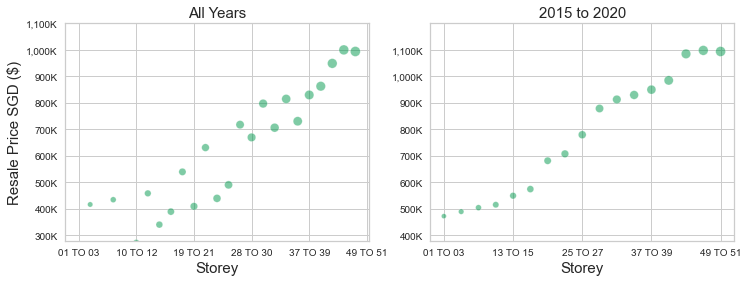

In [40]:
fig = plt.figure(figsize=(12,4))

# Storey Prices
ax1 = plt.subplot(121)
storey = prices.groupby('storey_range')['resale_price'].median().reset_index().sort_values(by='storey_range')
storey['storey_rank'] = storey['storey_range'].astype('category').cat.codes 
a=sns.scatterplot(x=storey['storey_rank'], y=storey['resale_price'], size=storey['storey_rank'].astype('int')*30, color='#00994d', edgecolors='w', alpha=0.5, legend=False, ax=ax1)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in a.get_yticks()/1000]
ax1.set_yticklabels(ylabels)
ax1.set_xticklabels(pd.Series(['']).append(storey.iloc[[0,5,10,15,20,24],0]))
ax1.set_ylim([280000,1100000]), ax1.set_ylabel('Resale Price SGD ($)', size=15), ax1.set_xlabel('Storey', size=15)
ax1.set_title('All Years', size=15)

# Floor Area Prices
ax2 = plt.subplot(122)
storey2 = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020])].groupby('storey_range')['resale_price'].median().reset_index().sort_values(by='storey_range')
storey2['storey_rank'] = storey2['storey_range'].astype('category').cat.codes

# Bubble chart
b=sns.scatterplot(x=storey2['storey_rank'], y=storey2['resale_price'], size=storey2['storey_rank'].astype('int')*30, color='#00994d', edgecolors='w', alpha=0.5, legend=False, ax=ax2)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000]
ax2.set_yticklabels(ylabels); ax2.set_ylabel('')
ax2.set_xticks([0,4,8,12,16])
ax2.set_xticklabels(storey2.iloc[[0,4,8,12,16],0])
ax2.set_ylim([280000,1100000]), ax2.set_xlabel('Storey', size=15)
ax2.set_title('2015 to 2020', size=15)

plt.show()

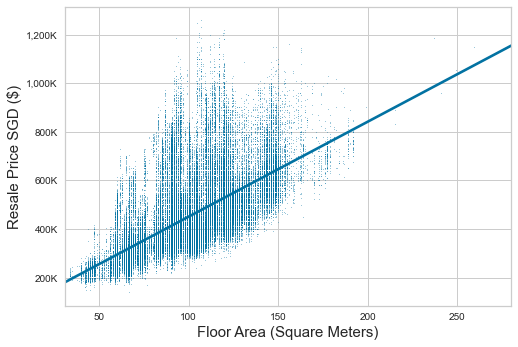

In [41]:
# Floor Area Prices
area = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020])]
p=sns.regplot(x='area_sqm', y='resale_price', data=area, scatter_kws={"s": 1, 'alpha':0.5})
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
p.set_xlabel('Floor Area (Square Meters)', size=15)
plt.show()

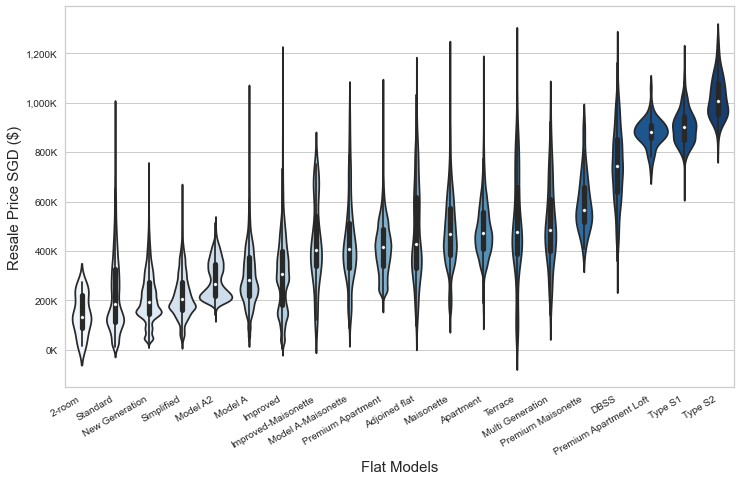

In [42]:
# Violin plots for price distribution of each flat model

fig = plt.figure(figsize=(12,7))
p=sns.violinplot(x='flat_model', y='resale_price', data=prices, width=1, palette="Blues",
                order=prices.groupby('flat_model')['resale_price'].median().sort_values().reset_index()['flat_model'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right'), p.set_xlabel('Flat Models', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
plt.show()

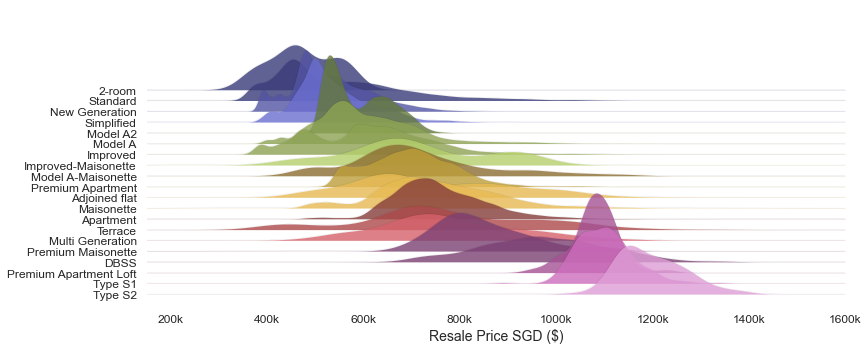

In [43]:
#ridgeline plot

flat_median = prices.set_index('flat_model')
flat_median = flat_median.loc[prices.groupby('flat_model')['resale_price'].median().sort_values().reset_index()['flat_model'].tolist()].reset_index().groupby("flat_model", sort=False)
fig, axes = joypy.joyplot(flat_median, by="flat_model", column="resale_price",figsize=(12,5),
             linewidth=0.05,overlap=1.5,alpha=0.8,colormap=plt.cm.get_cmap('tab20b',16))
axes[-1].set_xlim([-50000,1400000])
axes[-1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k', '1200k', '1400k','1600k']) 
plt.xlabel('Resale Price SGD ($)', fontsize=14)
fig.show()

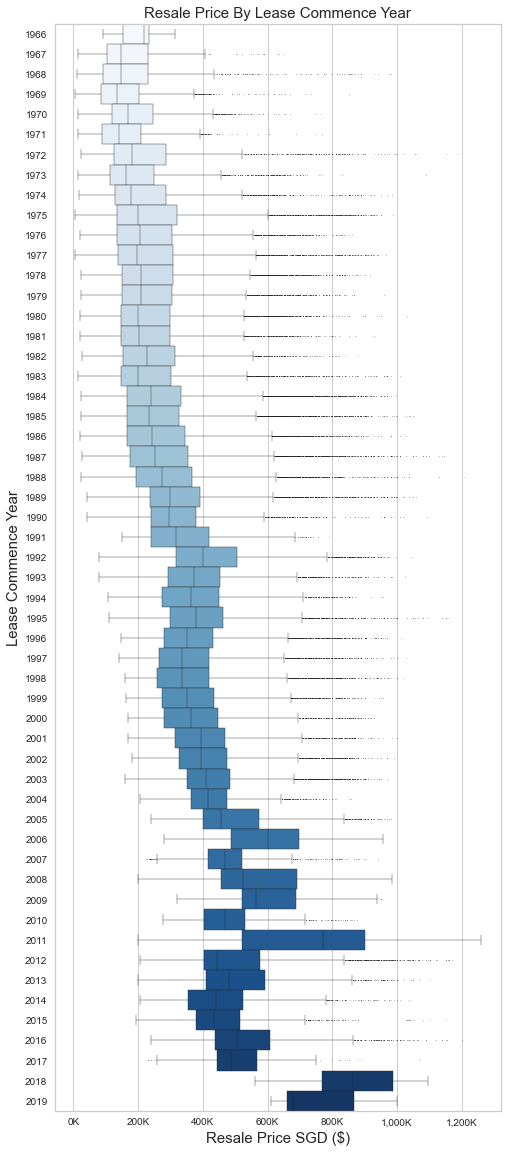

In [44]:
# Boxplot for each year of lease commence date

fig = plt.figure(figsize=(8,20))
p=sns.boxplot(y='lease_start', x='resale_price', data=prices, width=1, orient='h', flierprops = dict(markerfacecolor = 'red', markersize = 0.1, linestyle='none'), linewidth=0.4, palette="Blues")
p.set_xlabel('Resale Price SGD ($)', size=15), p.set_ylabel('Lease Commence Year', size=15)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
p.set_title('Resale Price By Lease Commence Year', size=15)
plt.show()

### High amount of outliers shown above
Above box plot indicate high amount of outliers in terms of resale price per start_lease (the year property starts as lease year 0.)
As this dataset is has a huge amount of outliers, and being a large dataset of 180000 rows of information, I sourced for oher methods such as Cook's distance to remove outliers which will be covered right before I perform Linear Regression. 
I may apply Stratsmodel 
Source: https://songhuiming.github.io/pages/2016/11/27/linear-regression-in-python-outliers-leverage-detect/

In [45]:
flat_amenities = pd.read_csv('flat_amenities.csv')

# merge amenities data to flat data
prices1520 = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020])]
prices1520['flat'] = prices['block'] + ' ' + prices['street_name']
prices1520 = prices1520.merge(flat_amenities, on='flat', how='left')

# reduce number of class of town to regions
d_region = {'Ang Mo Kio':'North East', 'Bedok':'East', 'Bishan':'Central', 'Bukit Batok':'West', 'Bukit Merah':'Central',
       'Bukit Panjang':'West', 'Bukit Timah':'Central', 'Central Area':'Central', 'Choa Chu Kang':'West',
       'Clementi':'West', 'Geylang':'Central', 'Hougang':'North East', 'Jurong East':'West', 'Jurong West':'West',
       'Kallang/Whampoa':'Central', 'Marine Parade':'Central', 'Pasir Ris':'East', 'Punggol':'North East',
       'Queenstown':'Central', 'Sembawang':'North', 'Sengkang':'North East', 'Serangoon':'North East', 'Tampines':'East',
       'Toa Payoh':'Central', 'Woodlands':'North', 'Yishun':'North'}
prices1520['region'] = prices1520['town'].map(d_region)
colors = {'North East':'Purple', 'East':'Green', 'Central':'Brown', 'West':'Red', 'North':'Orange'}

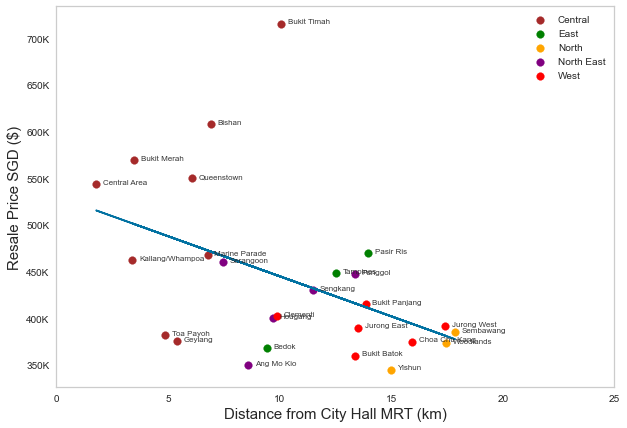

In [46]:
# get a property with the median value of each town in order to gauge the distance to City hall vs resale price
flat_median = prices1520.groupby('town')[['dist_city_hall','school_dist','num_school_2km','hawker_dist','num_hawker_2km','park_dist','num_park_2km','mall_dist','num_mall_2km','MRT_dist','num_MRT_2km','supermarket_dist','num_supermarket_2km','resale_price']].median().reset_index()
flat_median['region'] = flat_median['town'].map(d_region)

# Scatterplot with names of towns
fig, ax = plt.subplots(figsize=(10,7))
grouped = flat_median.groupby('region')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='dist_city_hall', y='resale_price', label=key, color=colors[key], s=60)
b, a = np.polyfit(flat_median['dist_city_hall'], flat_median['resale_price'], 1)
ax.plot(flat_median['dist_city_hall'], a + b* flat_median['dist_city_hall'], '-')  
ax.set_xlim([0,25]), ax.set_xlabel('Distance from City Hall MRT (km)', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels), ax.set_ylabel('Resale Price SGD ($)', size=15)
for i, txt in enumerate(flat_median['town']):
    ax.annotate(txt, (flat_median['dist_city_hall'][i]+0.3, flat_median['resale_price'][i]), size=8, alpha=0.9)
plt.grid(False)
plt.show()

We notice that Bukit Timah has the highest median price despite being further from city

In [47]:
prices1520.groupby('region')['resale_price'].median()

region
Central       500000.0
East          430000.0
North         368000.0
North East    427000.0
West          388000.0
Name: resale_price, dtype: float64

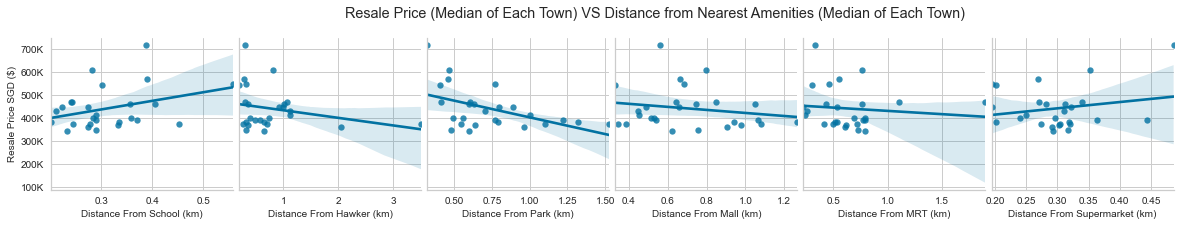

In [48]:
# scatterplot for median price of each town against nearest distance from each amenity

p=sns.pairplot(flat_median, x_vars=["school_dist", "hawker_dist", "park_dist", "mall_dist", "MRT_dist", "supermarket_dist"], y_vars=["resale_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Distance From School (km)', size=10), axes[0,1].set_xlabel('Distance From Hawker (km)', size=10)
axes[0,2].set_xlabel('Distance From Park (km)', size=10), axes[0,3].set_xlabel('Distance From Mall (km)', size=10)
axes[0,4].set_xlabel('Distance From MRT (km)', size=10), axes[0,5].set_xlabel('Distance From Supermarket (km)', size=10)
plt.suptitle('Resale Price (Median of Each Town) VS Distance from Nearest Amenities (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

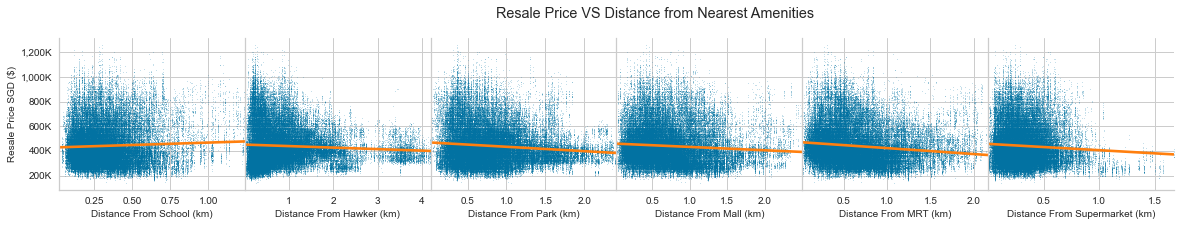

In [49]:
# scatterplot for price of each flat against nearest distance from each amenity

p=sns.pairplot(prices1520[prices1520['school_dist']<3], x_vars=["school_dist", "hawker_dist", "park_dist", "mall_dist", "MRT_dist", "supermarket_dist"], y_vars=["resale_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=0.5,alpha=0.3), line_kws=dict(color='#ff7f0e'))) # remove outliers (>3km)
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Distance From School (km)', size=10), axes[0,1].set_xlabel('Distance From Hawker (km)', size=10)
axes[0,2].set_xlabel('Distance From Park (km)', size=10), axes[0,3].set_xlabel('Distance From Mall (km)', size=10)
axes[0,4].set_xlabel('Distance From MRT (km)', size=10), axes[0,5].set_xlabel('Distance From Supermarket (km)', size=10)
plt.suptitle('Resale Price VS Distance from Nearest Amenities')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

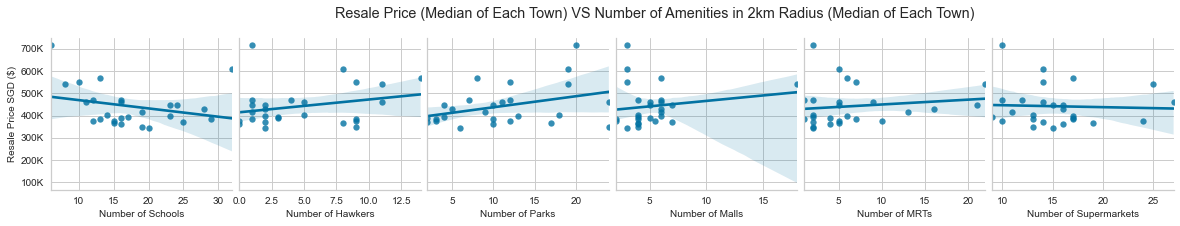

In [50]:
# scatterplot for median price of each town against various amenities within 2 km

p=sns.pairplot(flat_median, x_vars=["num_school_2km", "num_hawker_2km", "num_park_2km", "num_mall_2km", "num_MRT_2km", "num_supermarket_2km"], y_vars=["resale_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Number of Schools', size=10), axes[0,1].set_xlabel('Number of Hawkers', size=10)
axes[0,2].set_xlabel('Number of Parks', size=10), axes[0,3].set_xlabel('Number of Malls', size=10)
axes[0,4].set_xlabel('Number of MRTs', size=10), axes[0,5].set_xlabel('Number of Supermarkets', size=10)
plt.suptitle('Resale Price (Median of Each Town) VS Number of Amenities in 2km Radius (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

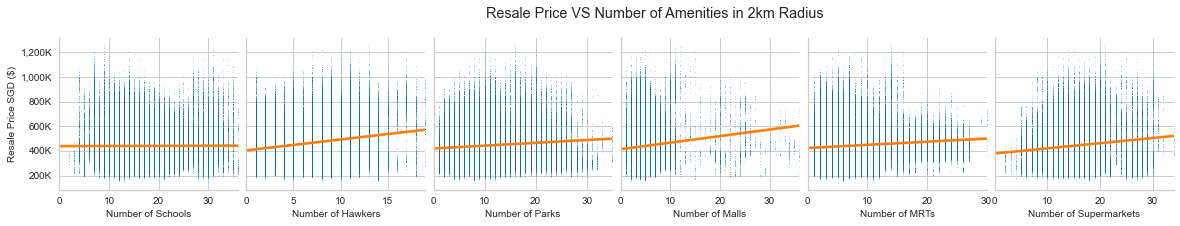

In [51]:
# scatterplot for price of each flat against various amenities within 2 km

p=sns.pairplot(prices1520, x_vars=["num_school_2km", "num_hawker_2km", "num_park_2km", "num_mall_2km", "num_MRT_2km", "num_supermarket_2km"], y_vars=["resale_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=0.5,alpha=0.3), line_kws=dict(color='#ff7f0e')))
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Number of Schools', size=10), axes[0,1].set_xlabel('Number of Hawkers', size=10)
axes[0,2].set_xlabel('Number of Parks', size=10), axes[0,3].set_xlabel('Number of Malls', size=10)
axes[0,4].set_xlabel('Number of MRTs', size=10), axes[0,5].set_xlabel('Number of Supermarkets', size=10)
plt.suptitle('Resale Price VS Number of Amenities in 2km Radius')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

In [52]:
df = prices1520[['town', 'flat_type', 'storey_range', 'area_sqm', 'flat_model', 'lease_start', 'year', 'school_dist', 'num_school_2km', 'hawker_dist', 'num_hawker_2km', 'park_dist', 'num_park_2km', 'mall_dist', 'num_mall_2km', 'MRT_dist', 'num_MRT_2km', 'supermarket_dist', 'num_supermarket_2km', 'dist_city_hall', 'region', 'resale_price']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124752 entries, 0 to 124751
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 124752 non-null  object 
 1   flat_type            124752 non-null  object 
 2   storey_range         124752 non-null  object 
 3   area_sqm             124752 non-null  float64
 4   flat_model           124752 non-null  object 
 5   lease_start          124752 non-null  int64  
 6   year                 124752 non-null  int64  
 7   school_dist          124752 non-null  float64
 8   num_school_2km       124752 non-null  int64  
 9   hawker_dist          124752 non-null  float64
 10  num_hawker_2km       124752 non-null  int64  
 11  park_dist            124752 non-null  float64
 12  num_park_2km         124752 non-null  int64  
 13  mall_dist            124752 non-null  float64
 14  num_mall_2km         124752 non-null  int64  
 15  MRT_dist         

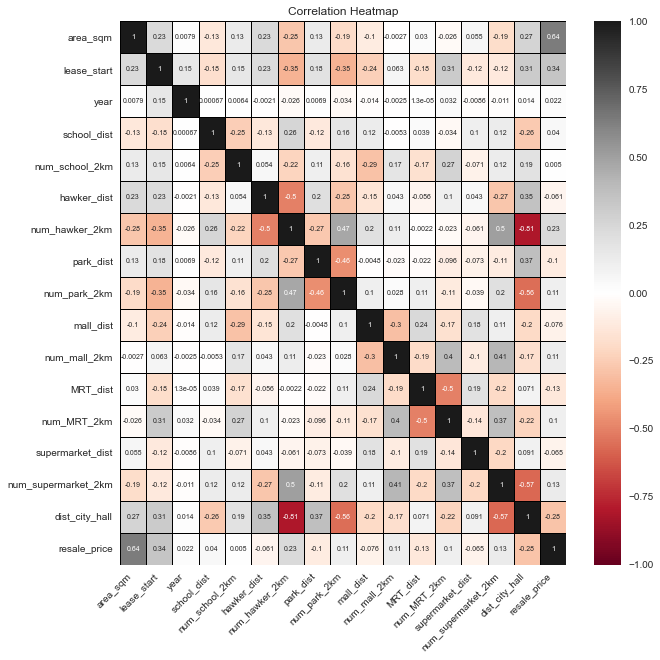

In [53]:
# Correlation heatmap
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'RdGy', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

### Issue of mulicolinearity
The regression model will not be able to determine the effects between independent variables and the dependent variables if the correlation value is too high. 

By using statsmodel variance_inflation_factor, we are able to see clearly the value it computes in order for us to remove features that need to be omitted for better model fitting.

In [54]:

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(df.drop('resale_price',axis=1).select_dtypes(include=['int64','float64']))

variables           VIF  tolerance      meanVIF
0              area_sqm     19.786329   0.050540  4728.069481
1           lease_start  37823.931255   0.000026  4728.069481
2                  year  37676.345344   0.000027  4728.069481
3           school_dist      4.672649   0.214011  4728.069481
4        num_school_2km     11.658998   0.085771  4728.069481
5           hawker_dist      3.357584   0.297833  4728.069481
6        num_hawker_2km      8.343315   0.119856  4728.069481
7             park_dist      6.234427   0.160400  4728.069481
8          num_park_2km      5.184097   0.192898  4728.069481
9             mall_dist      5.555372   0.180006  4728.069481
10         num_mall_2km      5.824261   0.171696  4728.069481
11             MRT_dist      5.163232   0.193677  4728.069481
12          num_MRT_2km      5.173394   0.193297  4728.069481
13     supermarket_dist      4.485319   0.222950  4728.069481
14  num_supermarket_2km     24.180423   0.041356  4728.069481
15       dist_city_hall     39.215697   0.025500  4728.069481

In [55]:
calc_vif(df.drop(['resale_price','num_supermarket_2km','year','num_school_2km','dist_city_hall'],axis=1).select_dtypes(include=['int64','float64']))

variables        VIF  tolerance   meanVIF
0           area_sqm  19.296259   0.051824  9.619294
1        lease_start  51.179258   0.019539  9.619294
2        school_dist   4.447373   0.224852  9.619294
3        hawker_dist   3.230216   0.309577  9.619294
4     num_hawker_2km   3.790478   0.263819  9.619294
5          park_dist   6.089868   0.164207  9.619294
6       num_park_2km   4.396469   0.227455  9.619294
7          mall_dist   4.853950   0.206018  9.619294
8       num_mall_2km   5.080865   0.196817  9.619294
9           MRT_dist   5.137274   0.194656  9.619294
10       num_MRT_2km   3.651458   0.273863  9.619294
11  supermarket_dist   4.278065   0.233751  9.619294

In [56]:
# drop columns
lr_df = df.drop(['num_supermarket_2km','year','num_school_2km','dist_city_hall'], axis=1)

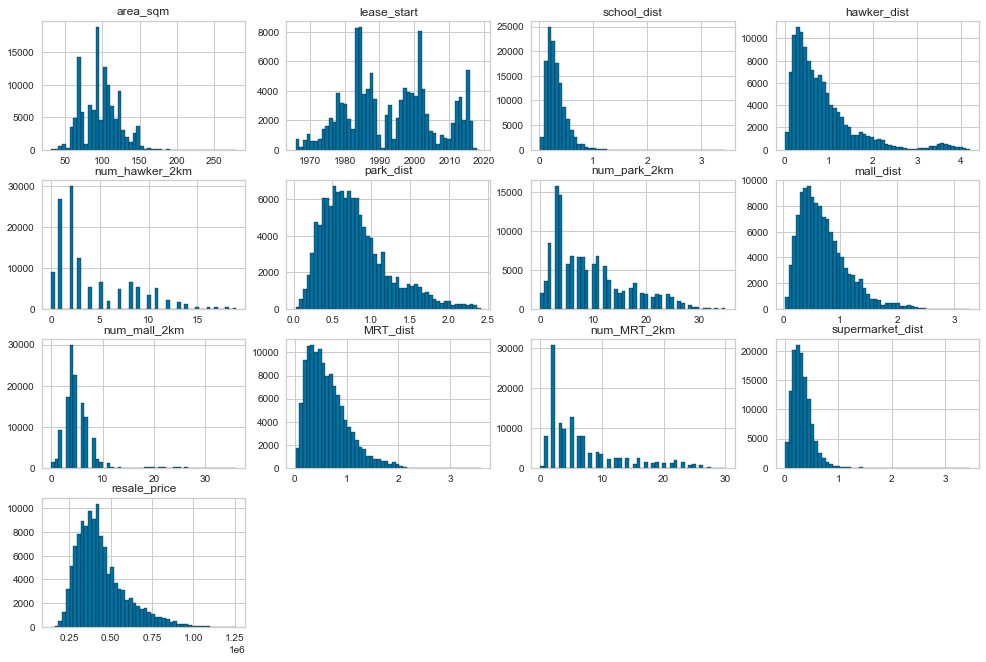

In [57]:
# Plot distribution for each continuous variable
lr_df.hist(bins=50, figsize=(15, 10), edgecolor='black')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.grid(False)
plt.show()

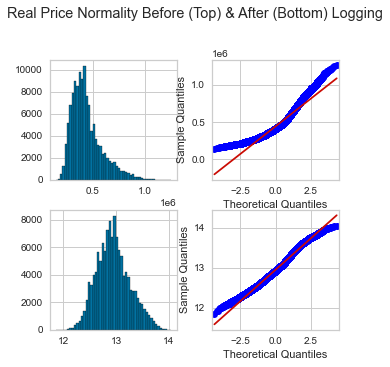

In [58]:
# plot qqplot before and after log transformation

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(lr_df['resale_price'], bins=50, edgecolor='black')
qqplot(lr_df['resale_price'], line='s', ax=ax2)
ax3.hist(np.log(lr_df['resale_price']), bins=50, edgecolor='black')
qqplot(np.log(lr_df['resale_price']), line='s', ax=ax4)
plt.suptitle('Real Price Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

### Applying logarithmic transformation
In order for us to reduce errors (without overfitting the model), we apply log transformation to normalize the data.
The above shows the difference after log transform is applied.

https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c#:~:text=The%20Why%3A,may%20also%20be%20skewed%20negatively.

### Feature Engineering
Now let's apply label encode to storey_range and flat_type based on number of rooms (as well as Executive with the largest value since they are the largest in size)

We will remove Multi Generation and '1 Room' as based on findings earlier, they have only 500 and 1000 records out of over 850 000 records.

We will also re-categorize flat models closest to the main flat_model model type.
With lesser categories to convert to dummy, data will be less sparse.!
Following is how we recategorize them.
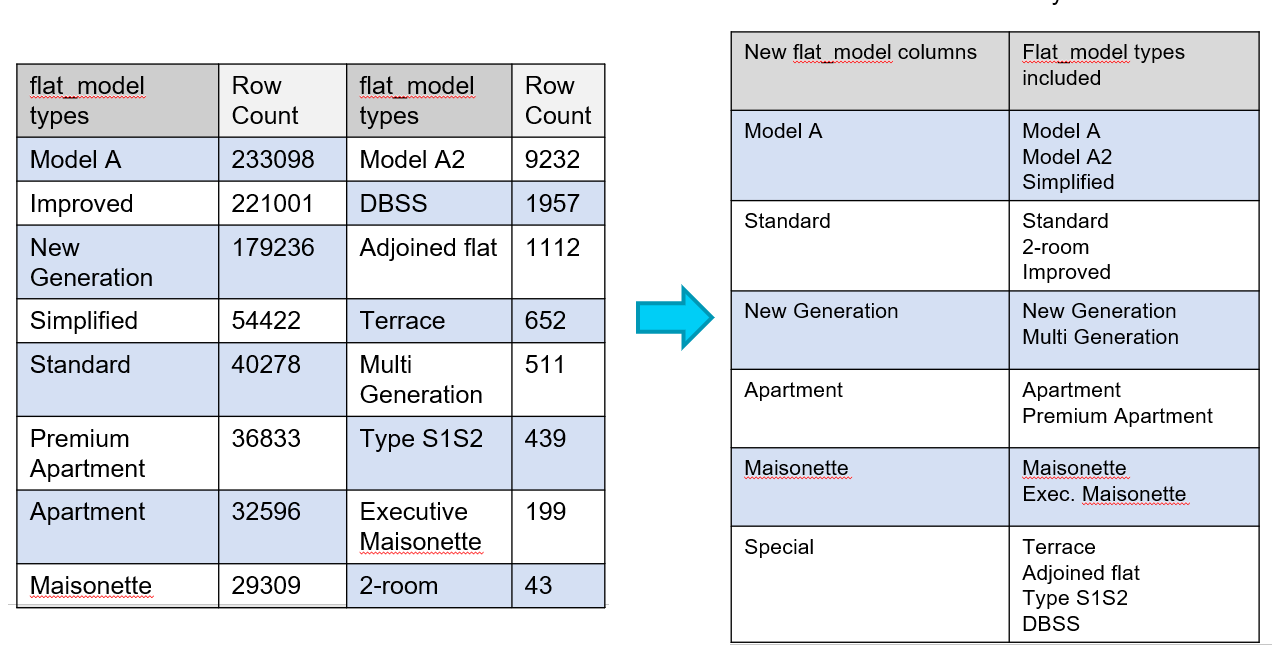

In [59]:
# label encode storeys
df = df.sort_values(by='storey_range')
df['storey_range'] = df['storey_range'].astype('category').cat.codes # label encode
lr_df = lr_df.sort_values(by='storey_range')
lr_df['storey_range'] = lr_df['storey_range'].astype('category').cat.codes # label encode

# remove flat types with very few cases
df = df[~df['flat_type'].isin(['MULTI GENERATION', '1 ROOM'])]
lr_df = lr_df[~lr_df['flat_type'].isin(['MULTI GENERATION', '1 ROOM'])]

# Re-categorize flat model to reduce num classes
replace_values = {'Model A2':'Model A', 'Simplified':'Model A',
                  'Improved':'Standard', '2-room':'Standard',
                  'Multi Generation' : 'New Generation',
                  'Premium Apartment':'Apartment', 'Premium Apartment Loft':'Apartment',
                  'Executive Maisonette':'Maisonette', 'Improved-Maisonette' :'Maisonette', 'Model A-Maisonette' :'Maisonette', 'Premium Maisonette' :'Maisonette', 
                  'Terrace':'Special', 'Adjoined flat':'Special', 'Type S1' :'Special', 'Type S2':'Special', 'DBSS':'Special'}
df = df.replace({'flat_model': replace_values})
lr_df = lr_df.replace({'flat_model': replace_values})

# Label encode flat type'
replace_values = {'2 ROOM':0, '3 ROOM':1, '4 ROOM':2, '5 ROOM':3, 'EXECUTIVE':4}
df = df.replace({'flat_type': replace_values})
lr_df = lr_df.replace({'flat_type': replace_values})

df = df.reset_index(drop=True)
display(df['flat_model'].value_counts())
lr_df = lr_df.reset_index(drop=True)
display(lr_df['flat_model'].value_counts())

Model A           46890
Standard          35069
New Generation    18242
Apartment         18117
Maisonette         3918
Special            2417
Name: flat_model, dtype: int64

Model A           46890
Standard          35069
New Generation    18242
Apartment         18117
Maisonette         3918
Special            2417
Name: flat_model, dtype: int64

In [60]:
## dummy encoding for df (the dataframe that includes 22 columns for regression)
df = pd.get_dummies(df, columns=['region'], prefix=['region'], drop_first=True) # central is baseline
df = pd.get_dummies(df, columns=['flat_model'], prefix=['model'])
df= df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

# dummy encoding lr_df to perform preprocessing for ML Linear Regression later
lr_df = pd.get_dummies(lr_df, columns=['region'], prefix=['region'], drop_first=True) # central is baseline
lr_df = pd.get_dummies(lr_df, columns=['flat_model'], prefix=['model'])
lr_df= lr_df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

In [61]:
df

town  flat_type  storey_range  area_sqm  lease_start  year  \
0             Yishun          1             0      68.0         1978  2020   
1           Clementi          1             0      67.0         1978  2019   
2            Hougang          0             0      47.0         2012  2017   
3         Queenstown          1             0      72.0         1970  2016   
4         Queenstown          1             0      70.0         1970  2016   
...              ...        ...           ...       ...          ...   ...   
124648  Central Area          2            16      94.0         2011  2015   
124649  Central Area          2            16      94.0         2011  2018   
124650  Central Area          2            16      94.0         2011  2020   
124651  Central Area          3            16     105.0         2011  2017   
124652  Central Area          2            16      94.0         2011  2016   

        school_dist  num_school_2km  hawker_dist  num_hawker_2km  ...  \
0          0.325531              20     0.174269               1  ...   
1          0.442763              15     0.312990               5  ...   
2          0.450176              23     0.793415               3  ...   
3          0.590311               9     0.202540              10  ...   
4          0.881604               9     0.294493              11  ...   
...             ...             ...          ...             ...  ...   
124648     0.154258               7     0.237236              11  ...   
124649     0.281474               9     0.280703              13  ...   
124650     0.234687               7     0.188984              11  ...   
124651     0.301776               9     0.235487              13  ...   
124652     0.301776               9     0.235487              13  ...   

        resale_price  region_East  region_North  region_North East  \
0           240000.0            0             1                  0   
1           315000.0            0             0                  0   
2           233000.0            0             0                  1   
3           357000.0            0             0                  0   
4           330000.0            0             0                  0   
...              ...          ...           ...                ...   
124648      910000.0            0             0                  0   
124649      999000.0            0             0                  0   
124650     1085000.0            0             0                  0   
124651     1108000.0            0             0                  0   
124652      938880.0            0             0                  0   

        region_West  model_Apartment  model_Maisonette  model_Model A  \
0                 0                0                 0              0   
1                 1                0                 0              0   
2                 0                0                 0              1   
3                 0                0                 0              0   
4                 0                0                 0              0   
...             ...              ...               ...            ...   
124648            0                0                 0              0   
124649            0                0                 0              0   
124650            0                0                 0              0   
124651            0                0                 0              0   
124652            0                0                 0              0   

        model_New Generation  model_Special  
0                          1              0  
1                          1              0  
2                          0              0  
3                          0              0  
4                          0              0  
...                      ...            ...  
124648                     0              1  
124649                     0              1  
124650                     0              1  
124651                  

In [62]:
lr_df

town  flat_type  storey_range  area_sqm  lease_start  \
0             Yishun          1             0      68.0         1978   
1           Clementi          1             0      67.0         1978   
2            Hougang          0             0      47.0         2012   
3         Queenstown          1             0      72.0         1970   
4         Queenstown          1             0      70.0         1970   
...              ...        ...           ...       ...          ...   
124648  Central Area          2            16      94.0         2011   
124649  Central Area          2            16      94.0         2011   
124650  Central Area          2            16      94.0         2011   
124651  Central Area          3            16     105.0         2011   
124652  Central Area          2            16      94.0         2011   

        school_dist  hawker_dist  num_hawker_2km  park_dist  num_park_2km  \
0          0.325531     0.174269               1   0.359149             7   
1          0.442763     0.312990               5   0.605731            19   
2          0.450176     0.793415               3   0.450754            18   
3          0.590311     0.202540              10   1.315904             7   
4          0.881604     0.294493              11   1.111670            11   
...             ...          ...             ...        ...           ...   
124648     0.154258     0.237236              11   0.614517            14   
124649     0.281474     0.280703              13   0.367658            16   
124650     0.234687     0.188984              11   0.464857            16   
124651     0.301776     0.235487              13   0.368256            16   
124652     0.301776     0.235487              13   0.368256            16   

        ...  resale_price  region_East  region_North  region_North East  \
0       ...      240000.0            0             1                  0   
1       ...      315000.0            0             0                  0   
2       ...      233000.0            0             0                  1   
3       ...      357000.0            0             0                  0   
4       ...      330000.0            0             0                  0   
...     ...           ...          ...           ...                ...   
124648  ...      910000.0            0             0                  0   
124649  ...      999000.0            0             0                  0   
124650  ...     1085000.0            0             0                  0   
124651  ...     1108000.0            0             0                  0   
124652  ...      938880.0            0             0                  0   

        region_West  model_Apartment  model_Maisonette  model_Model A  \
0                 0                0                 0              0   
1                 1                0                 0              0   
2                 0                0                 0              1   
3                 0                0                 0              0   
4                 0                0                 0              0   
...             ...              ...               ...            ...   
124648            0                0                 0              0   
124649            0                0                 0              0   
124650            0                0                 0              0   
124651            0                0                 0              0   
124652            0                0                 0              0   

        model_New Generation  model_Special  
0                          1              0  
1                          1              0  
2                          0              0  
3                          0              0  
4                          0              0  
...                      ...            ...  
124648                     0              1  
124649                     0              1  
124650                     0      

### Standard scaler applied before conducting linear Regression
We apply standard scaler to remove the mean and scales each feature/variable to unit variance. This is so as variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. 

To visualize residuals better, we will apply Cooks' Distance visualizer.
https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832

In [63]:


scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['area_sqm','lease_start','school_dist','hawker_dist','num_hawker_2km','park_dist',
                    'num_park_2km', 'mall_dist', 'num_mall_2km', 'MRT_dist', 'num_MRT_2km', 'supermarket_dist']
scaler.fit(lr_df[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(lr_df[scaled_columns]), index=lr_df.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = lr_df.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
lr_df = pd.concat([scaled_columns,unscaled_columns], axis=1)

In [64]:
display(lr_df.head())

area_sqm  lease_start  school_dist  hawker_dist  num_hawker_2km  park_dist  \
0 -1.220097    -1.226621     0.042840    -0.916391       -0.796546  -1.019420   
1 -1.261437    -1.226621     0.687456    -0.730231        0.235200  -0.444424   
2 -2.088220     1.495946     0.728218    -0.085511       -0.280673  -0.805809   
3 -1.054741    -1.867225     1.498775    -0.878451        1.524882   1.211606   
4 -1.137419    -1.867225     3.100495    -0.755053        1.782819   0.735358   

   num_park_2km  mall_dist  num_mall_2km  MRT_dist  ...  resale_price  \
0     -0.317008   0.794296     -0.361303  0.648738  ...      240000.0   
1      1.423107  -0.628167     -0.361303 -0.298981  ...      315000.0   
2      1.278097  -0.891462     -0.034817  1.104901  ...      233000.0   
3     -0.317008  -0.773171     -0.687790 -0.741498  ...      357000.0   
4      0.263030  -0.750579     -0.361303 -0.002283  ...      330000.0   

   region_East region_North  region_North East  region_West  model_Apartment  \
0            0            1                  0            0                0   
1            0            0                  0            1                0   
2            0            0                  1            0                0   
3            0            0                  0            0                0   
4            0            0                  0            0                0   

   model_Maisonette  model_Model A  model_New Generation  model_Special  
0                 0              0                     1              0  
1                 0              0                     1              0  
2                 0              1                     0              0  
3                 0              0                     0              0  
4                 0              0                     0              0  

[5 rows x 25 columns]

In [65]:
lr_df.to_csv(r'lr_HDB')

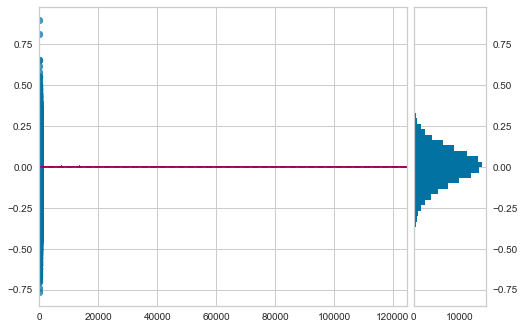

In [66]:
#Split
lr_y = lr_df[['resale_price']]
lr_X = lr_df.drop(['resale_price','town'], axis=1)

#Handling skewed data via log algorithm
yy = np.log(lr_y)['resale_price']
XX = lr_X.values

# Apply Cooks distance to visualise residuals outliers
visualizer = CooksDistance()
visualizer.fit(XX, yy)

# visualize residuals before outlier removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(XX, yy)

plt.show()

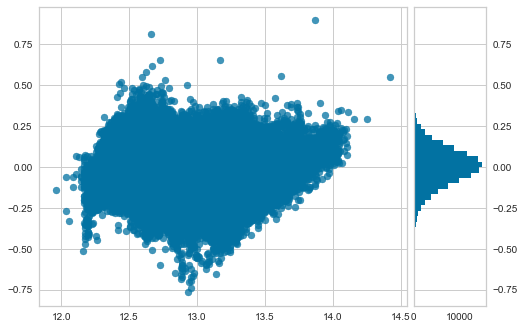

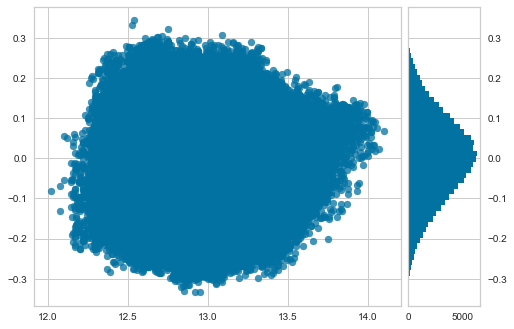

In [67]:
# visualize residuals before outlier removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(XX, yy)
#visualizer_residuals.show()
plt.show()

# remove outliers
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = XX[i_less_influential], yy[i_less_influential]
lr_X, lr_y = lr_X[i_less_influential], lr_y[i_less_influential]

# visualize residuals after outliers removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
#visualizer_residuals.show()

plt.show()

### Outliers removed
Above method shows how outliers residual values are removed. 